In [1]:
import os
import time
from DRA_GAN import *
import numpy as np
from torchvision.utils import save_image
import torch.optim as optim
from torch.autograd import grad

In [2]:
EPOCHS = 200
BATCH_SIZE = 100
N_WORKERS = 4
HIDDEN_DIM = 100
learning_rates = 0.0002
betas = (0.5, 0.999)
N_CLASS = 10
OUTPUT_IMG_GAP = 500

In [3]:
import torchvision.transforms as transforms
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

import torchvision.datasets as dset
from torch.utils.data import DataLoader

DATA_ROOT = "./data"
train_set = dset.CIFAR10(
    root=DATA_ROOT,
    train=True,
    download=True,
    transform=transform_train
)
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=N_WORKERS
)
from torchvision import datasets
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor(), transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
data_loader = DataLoader(
    datasets.CIFAR10('data/cifar10', train=True, download=True, transform=transform),
    batch_size=BATCH_SIZE, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    print("GPU USED FOR TRAINING")
else:
    print("CPU USED FOR TRAINING")

# define the model
generator = Generator()
discriminator = Discriminator()

# define the optimizers
optimizer_gen = optim.Adam(generator.parameters(), lr=learning_rates, betas=betas)
optimizer_dis = optim.Adam(discriminator.parameters(), lr=learning_rates, betas=betas)

# define the loss function
dis_loss = nn.BCELoss().to(device)

generator = generator.to(device)
discriminator = discriminator.to(device)
print(generator)
print(discriminator)

GPU USED FOR TRAINING
Generator(
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=8192, bias=True)
    (4): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (deconv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Tanh()
  )
)
Discriminator(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine

In [5]:
start = time.time()
print("==> Training starts!")
print("="*100)
lossG_history = []
lossD_history = []

fixed_noise = None
discriminator.train()
real_ones = torch.ones((BATCH_SIZE, 1), device=device)
fake_ones = torch.zeros((BATCH_SIZE, 1), device=device)

for i in range(EPOCHS):
    epoch_start = time.time()
    print("Epoch %d:" %i)
    generator.train()

    lossG_record = []
    lossD_record = []
    for batch_idx, (inputs, targets) in enumerate(data_loader):
        inputs = inputs.float().to(device)
        targets = targets.type(torch.LongTensor).to(device)
        batch_size = inputs.shape[0]
        # Train Generator
        noise = torch.randn(batch_size, HIDDEN_DIM).to(device)
        if fixed_noise is None:
            fixed_noise = noise.clone().detach().to(device)

        optimizer_dis.zero_grad()
        real = discriminator(inputs)
        real_loss = dis_loss(real, real_ones)
        
        # give the generator
        img = generator(noise)
        fake = discriminator(img)
        fake_loss = dis_loss(fake, fake_ones)

        """ DRAGAN Loss (Gradient penalty) """
        # This is borrowed from https://github.com/kodalinaveen3/DRAGAN/blob/master/DRAGAN.ipynb
        alpha = torch.rand(batch_size, 1, 1, 1).cuda()
        alpha = alpha.cuda()
        x_p = inputs + 0.5 * inputs.std() * torch.rand(inputs.size()).cuda()
        differences = x_p - inputs
        interpolates = inputs + (alpha * differences)
        interpolates.requires_grad = True
        pred_hat = discriminator(interpolates)
        gradients = grad(outputs=pred_hat, inputs=interpolates, grad_outputs=torch.ones(pred_hat.size()).cuda(),
                         create_graph=True, retain_graph=True, only_inputs=True)[0]
        gradient_penalty = 1.2 * ((gradients.view(gradients.size()[0], -1).norm(2, 1) - 1) ** 2).mean()

        loss = real_loss + fake_loss + gradient_penalty
        lossD_record.append(loss.cpu().detach().numpy())
        loss.backward()
        optimizer_dis.step()
        
        optimizer_gen.zero_grad()
        img2 = generator(noise)
        fake2 = discriminator(img2)
        
        loss2 = dis_loss(fake2, real_ones)
        lossG_record.append(loss2.cpu().detach().numpy())
        loss2.backward()
        optimizer_gen.step()
        
        # output images
        if batch_idx % OUTPUT_IMG_GAP == 0:
            batches_done = i * len(train_loader) + batch_idx
            generated_images = generator(fixed_noise).data[:50]
            save_image(generated_images, os.path.join('./images', "%d.png" % batches_done), nrow=5, normalize=True)

    avg_loss_g = np.sum(np.asarray(lossG_record)) / len(lossG_record)
    avg_loss_d = np.sum(np.asarray(lossD_record)) / len(lossD_record)
    print("Generator loss: %.4f, Discriminator loss: %.4f"%(avg_loss_g, avg_loss_d))

    lossG_history.append(avg_loss_g)
    lossD_history.append(avg_loss_d)

    # save the model checkpoint
    torch.save(generator.state_dict(), os.path.join('./model', 'generator.pth'))
    torch.save(discriminator.state_dict(), os.path.join('./model', 'discriminator.pth'))
    print(f"Epoch finished in {time.time() - epoch_start:.2f}s")
    print("")

print("="*100)
print(f"==> Optimization finished in {time.time() - start:.2f}s!")

==> Training starts!
Epoch 0:
Generator loss: 1.0507, Discriminator loss: 1.4488
Epoch finished in 35.23s

Epoch 1:
Generator loss: 1.0326, Discriminator loss: 1.3776
Epoch finished in 32.68s

Epoch 2:
Generator loss: 0.8793, Discriminator loss: 1.3874
Epoch finished in 32.89s

Epoch 3:
Generator loss: 0.8837, Discriminator loss: 1.3480
Epoch finished in 33.34s

Epoch 4:
Generator loss: 0.8913, Discriminator loss: 1.3417
Epoch finished in 33.26s

Epoch 5:
Generator loss: 0.9169, Discriminator loss: 1.3192
Epoch finished in 33.59s

Epoch 6:
Generator loss: 0.9606, Discriminator loss: 1.2856
Epoch finished in 33.46s

Epoch 7:
Generator loss: 0.9681, Discriminator loss: 1.2847
Epoch finished in 36.06s

Epoch 8:
Generator loss: 0.9689, Discriminator loss: 1.2785
Epoch finished in 33.75s

Epoch 9:
Generator loss: 1.0154, Discriminator loss: 1.2589
Epoch finished in 33.69s

Epoch 10:
Generator loss: 1.0091, Discriminator loss: 1.2340
Epoch finished in 34.24s

Epoch 11:
Generator loss: 1.0166

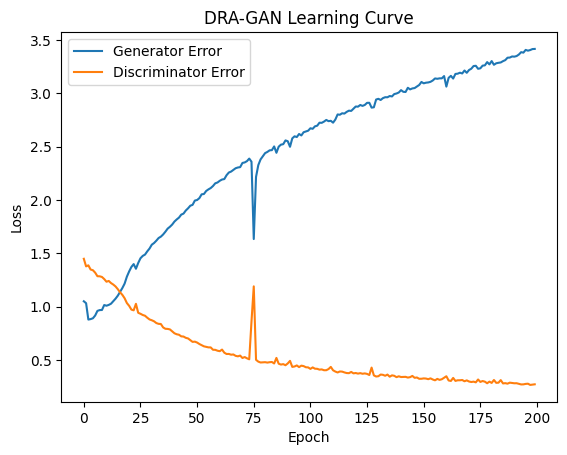

In [6]:
import matplotlib.pyplot as plt
plt.plot(lossG_history, label='Generator Error')
plt.plot(lossD_history, label='Discriminator Error')
plt.title("DRA-GAN Learning Curve")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()